## Read in the Data

In [6]:
import pandas as pd
import numpy as np
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("datasets/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Read in the Surveys

In [7]:
all_survey = pd.read_csv("datasets/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("datasets/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey[survey_fields]
data["survey"] = survey

C:\Users\Ibrahim\AppData\Local\Temp\ipykernel_9548\4041477741.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  survey["DBN"] = survey["dbn"]


## Add DBN Columns

In [8]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert Columns to Numeric

In [9]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["location"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["location"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense Datasets

In [10]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

# Ensure "DBN" is retained while selecting numeric columns
dbn = class_size["DBN"]
numeric_class_size = class_size.select_dtypes(exclude=['object'])

# Add "DBN" back to the numeric dataframe
numeric_class_size["DBN"] = dbn
class_size = numeric_class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

C:\Users\Ibrahim\AppData\Local\Temp\ipykernel_9548\1566381879.py:11: FutureWarning: The provided callable <function mean at 0x0000029E50CABAC0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  class_size = numeric_class_size.groupby("DBN").agg(np.mean)


## Convert AP Scores to Numeric

In [11]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the Datasets

In [12]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")
means=combined.select_dtypes(exclude=['object']).mean()
combined = combined.fillna(means)
combined = combined.fillna(0)

C:\Users\Ibrahim\AppData\Local\Temp\ipykernel_9548\3288959511.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined = combined.fillna(0)


## Add a School District Column for Mapping

In [13]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

C:\Users\Ibrahim\AppData\Local\Temp\ipykernel_9548\1203636352.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)


## Find Correlations

In [14]:
correlations = combined.select_dtypes(exclude=['object']).corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.985814
SAT Math Avg. Score                0.972656
SAT Writing Avg. Score             0.987555
sat_score                          1.000000
AP Test Takers                     0.520246
                                     ...   
Census Tract                       0.050059
BIN                                0.051991
BBL                                0.043574
lat                               -0.112448
lon                               -0.129483
Name: sat_score, Length: 300, dtype: float64


## Plotting Survey Correlations

In [15]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

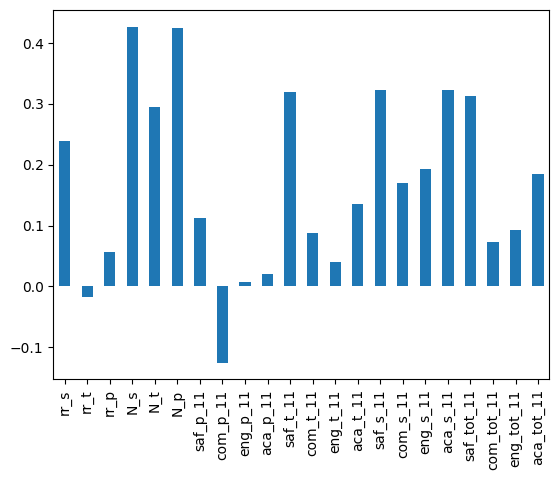

In [16]:
import matplotlib.pyplot as plt
survey_corr=correlations[survey_fields]
survey_corr.plot(kind='bar')
plt.show()

There are high correlations between N_s, N_t, N_p, and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense — it's difficult to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

## Exploring Safety

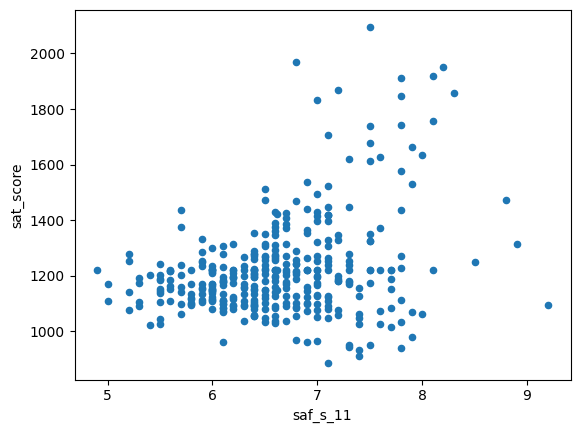

In [17]:
combined.plot.scatter(x='saf_s_11', y='sat_score')
plt.show()

There appears to be a correlation between SAT scores and safety, although it isn't very strong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

In [18]:
boro = combined['boro']
numeric_combined = combined.select_dtypes(include='number')
numeric_combined['boro'] = boro
average_safety = numeric_combined.groupby('boro').agg(np.mean)['saf_s_11']
print(average_safety)

boro
K    6.390741
M    6.857575
Q    6.721875
R    6.530000
X    6.591425
Name: saf_s_11, dtype: float64


C:\Users\Ibrahim\AppData\Local\Temp\ipykernel_9548\2410543475.py:4: FutureWarning: The provided callable <function mean at 0x0000029E50CABAC0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  average_safety = numeric_combined.groupby('boro').agg(np.mean)['saf_s_11']


## Racial Differences in SAT Scores

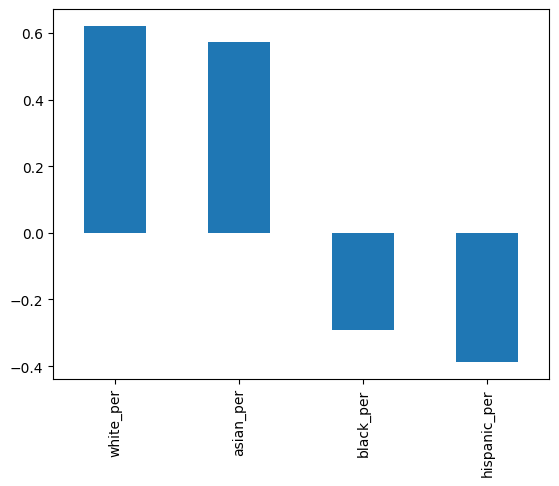

In [19]:
racial_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
racial_corr=correlations[racial_cols]
racial_corr.plot(kind='bar')
plt.show()

It looks like a higher percentage of white or Asian students at a school correlates positively with SAT scores, whereas a higher percentage of black or Hispanic students correlates negatively with SAT score. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or Hispanic students.

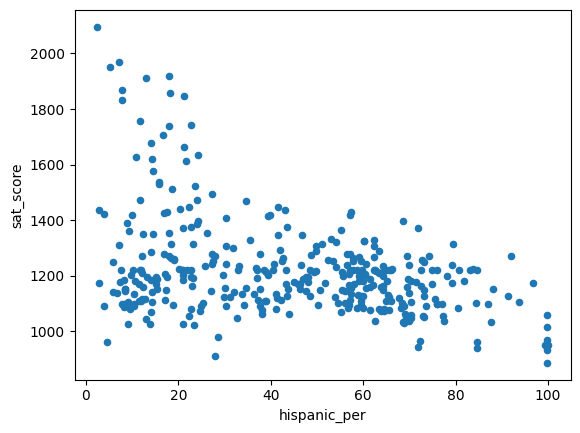

In [20]:
combined.plot.scatter(x='hispanic_per', y='sat_score')
plt.show()

The schools listed above appear to primarily serve recent immigrants to the U.S. These schools have many students who are learning English, which would explain the lower SAT scores.

In [21]:
hispanic_95 = combined[combined['hispanic_per']>95]
print(hispanic_95['SCHOOL NAME'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
83      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
90     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
175     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
252                            MULTICULTURAL HIGH SCHOOL
287               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools listed above appear to primarily serve recent immigrants to the U.S. These schools have many students who are learning English, which would explain the lower SAT scores.

In [22]:
hispanic_10_high_sat = combined[(combined['hispanic_per']<10) & (combined['sat_score']>1800)]
print(hispanic_10_high_sat['SCHOOL NAME'])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
186                       BROOKLYN TECHNICAL HIGH SCHOOL
328    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
357                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Many of the schools above appear to be specialized science and technology schools that receive extra funding and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT — they are students from all over New York City who did well on a standardized test.

## Gender Differences in SAT Scores

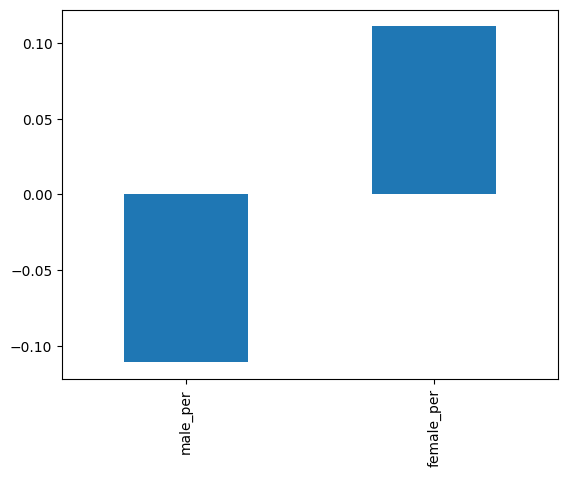

In [23]:
gender_cols= ['male_per', 'female_per']
correlations[gender_cols].plot(kind='bar')
plt.show()

In the plot above, we can see that a high percentage of females at a school positively correlates with SAT scores, whereas a high percentage of males at a school negatively correlates with SAT scores. Neither correlation is extremely strong.

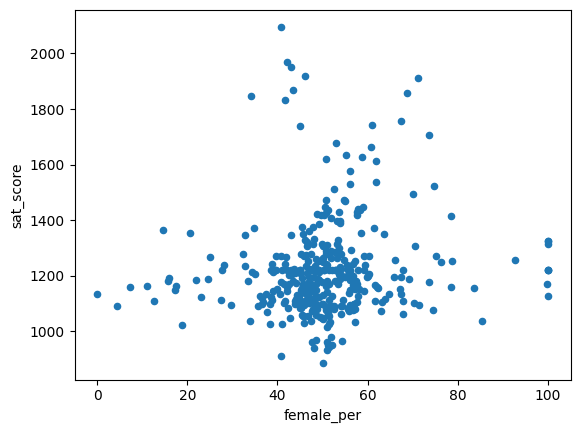

In [24]:
combined.plot.scatter(x='female_per', y='sat_score')
plt.show()

Based on the scatter plot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80) and high SAT scores.

In [25]:
female_60_sat_1800 = combined[(combined['female_per']>60) & (combined['sat_score']>1700)]
print(female_60_sat_1800['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
61                                    BEACON HIGH SCHOOL
62     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
303                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools appear to be very selective liberal arts schools that have high academic standards.

## AP Exam Scores vs. SAT Scores

C:\Users\Ibrahim\AppData\Local\Temp\ipykernel_9548\2825428578.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']


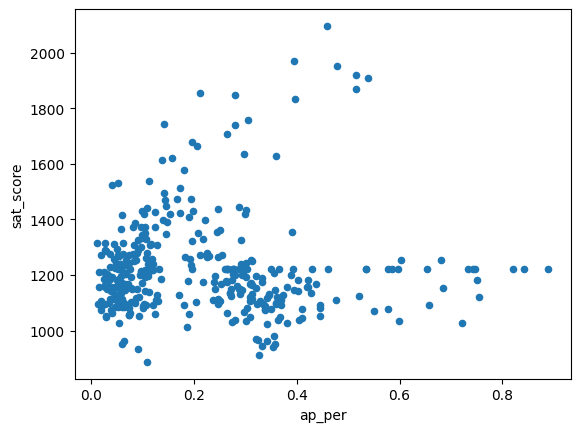

In [26]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']
combined.plot.scatter(x='ap_per', y='sat_score')
plt.show()

It looks like there is a relationship between the percentage of students in a school who take the AP exam and their average SAT scores. It's not a very strong correlation, however.